In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.autograd as autograd
from torch.autograd import Variable
import ConfigParser
import cPickle as pickle
from time import time

In [2]:
config = ConfigParser.ConfigParser()
config.readfp(open(r'../src/config.ini'))
SAVE_PATH = config.get('paths', 'save_path')
TRAIN_TEST_FILE_NAME = "data_train_test_100.dat"
filename = SAVE_PATH + TRAIN_TEST_FILE_NAME
with open(filename) as f:  # Python 3: open(..., 'rb')
    train_data = pickle.load(f)

DATA_FILE_NAME = config.get('paths', 'extracted_data_file_name')
filename = SAVE_PATH + DATA_FILE_NAME

tic1 = time()
with open(filename) as f:  # Python 3: open(..., 'rb')
    train_text_df, train_idx_df, dev_idx_df, embeddings, word_to_idx = pickle.load(f)
toc1 = time()
print "elapsed time to retrieve extracted data from file: %.2f sec" %(toc1 - tic1)

elapsed time to retrieve extracted data from file: 32.27 sec


In [3]:
del train_text_df
del train_idx_df
del dev_idx_df

In [33]:
class  CNN(nn.Module):
    def __init__(self, embed_num, embed_dim, kernel_num, kernel_sizes):
        super(CNN,self).__init__()
        V = embed_num
        D = embed_dim
        Ci = 1 #input channel
        Co = kernel_num #depth
        Ks = kernel_sizes #height of each filter

        self.embed = nn.Embedding(V, D)
        self.embed.weight.data = torch.from_numpy(embeddings)
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        #self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #print "begin: "+str(x.size())
        x = self.embed(x) # (N,W,D)
        
        #print "after embedding: "+ str(x.size())
        #if self.args.static:
        #    x = Variable(x)

        x = x.unsqueeze(1) # (N,Ci,W,D)
        #print "after unsqueeze: "+ str(x.size())
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] #[(N,Co,W), ...]*len(Ks)
        
        #print "after relu: "+ str(len(x)) #+ "::" + str(x[0].size())+ "::" + str(x[1].size())
          
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)
        #print "after max_pool1d: " + "::" + str(x[0].size())+ str(x[1].size())+"::" + str(x[2].size())
        
        x = torch.cat(x, 1)
        #print "after torch cat final step: "+ "::" + str(x[0].size())+ str(x[1].size())+"::" + str(x[2].size())
        #print "---"
        #sys.exit(0)
        #x = self.dropout(x) # (N,len(Ks)*Co)
        return x


In [34]:
embed_num = len(word_to_idx)
embed_dim = len(embeddings[0])
kernel_num = 100
kernel_sizes = range(2,6)
batch_size = 32
model = CNN(embed_num, embed_dim, kernel_num, kernel_sizes)

learning_rate = 1e-3
weight_decay = 1e-3
print model

#define loss and optimizer
criterion = nn.MultiMarginLoss(p=1, margin=2, size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training_loss = []
validation_loss = []



CNN (
  (embed): Embedding(100406, 200)
  (convs1): ModuleList (
    (0): Conv2d(1, 100, kernel_size=(2, 200), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(4, 200), stride=(1, 1))
  )
)


In [35]:
print "Begin training..."
num_epochs = 10
for epoch in range(num_epochs):
    
    running_train_loss = 0.0
    
    train_data_loader = torch.utils.data.DataLoader(
        train_data, 
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4, 
        drop_last = True)
        
    model.train()
    
    for batch in train_data_loader:
        query_title = Variable(batch['query_title'])
        query_body = Variable(batch['query_body'])
        similar_title = Variable(batch['similar_title'])
        similar_body = Variable(batch['similar_body'])
        
        random_title_list = []
        random_body_list = []
        for ridx in range(10):  #range(100)
            random_title_name = 'random_title_' + str(ridx)
            random_body_name = 'random_body_' + str(ridx)
            random_title_list.append(Variable(batch[random_title_name]))
            random_body_list.append(Variable(batch[random_body_name]))
        
        
        optimizer.zero_grad()
        
        lstm_query_title = model(query_title)
        lstm_query_body = model(query_body)
        lstm_query = (lstm_query_title + lstm_query_body)/2.0
        
        print "::query similar title::" 
        lstm_similar_title = model(similar_title)
        print "::query similar body::" 
        lstm_similar_body = model(similar_body)
        lstm_similar = (lstm_similar_title + lstm_similar_body)/2.0
        
        
        lstm_random_list = []
        print "::random title body process::" 
        
        for ridx in range(len(random_title_list)):
            lstm_random_title = model(random_title_list[ridx])
            lstm_random_body = model(random_body_list[ridx])
            lstm_random = (lstm_random_title + lstm_random_body)/2.0
            lstm_random_list.append(lstm_random)
            #lstm_random_list.append(lstm_random_body)
            
        
        print "done random processing.."
        cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
        score_pos = cosine_similarity(lstm_query, lstm_similar)

        score_list = []
        score_list1 = []
        
        score_list.append(score_pos)
        score_list1.append(score_pos.data.numpy())
        print "::query random title body::" 
        for ridx in range(len(lstm_random_list)):
            score_neg = cosine_similarity(lstm_query, lstm_random_list[ridx])
            score_list.append(score_neg)
            score_list1.append(score_neg.data.numpy())
        
        print "::done scoring::"
        
        '''
        diff = score_list1[0] - np.median(score_list1[1:])
        plt.plot(diff)
        plt.show()
        '''
        
        X_scores = torch.stack(score_list, 1) #[batch_size, K=101]
        #y_targets = Variable(torch.zeros(X_scores.size(0)).type(torch.LongTensor)) #[batch_size]
        y_targets = Variable(torch.zeros(X_scores.size(0)).type(torch.LongTensor)) #[batch_size]
        
        loss = criterion(X_scores, y_targets) #y_target=0
        loss.backward()
        optimizer.step()
        
        print "::batch end::"
        running_train_loss += loss.cpu().data[0]        
        
    #end for
    training_loss.append(running_train_loss)
    print "epoch: %4d, training loss: %.4f" %(epoch+1, running_train_loss)
    
    #torch.save(model, SAVE_PATH)
#end for

Begin training...
begin: torch.Size([32, 20])
after embedding: torch.Size([32, 20, 200])
after unsqueeze: torch.Size([32, 1, 20, 200])
after relu: 3
after max_pool1d: ::torch.Size([32, 100])torch.Size([32, 100])::torch.Size([32, 100])
after torch cat final step: ::torch.Size([300])torch.Size([300])::torch.Size([300])


NameError: global name 'sys' is not defined

ZMQError: Too many open files

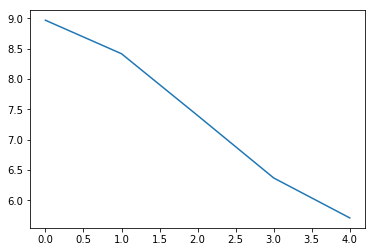

In [27]:
plt.plot(training_loss)
plt.show()